<a href="https://colab.research.google.com/github/codebylakshay/ProJect-2/blob/main/Analyze_sentiment_in_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, roc_curve, auc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')

In [ ]:
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. The filming tec...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

In [ ]:
data['cleaned_review'] = data['review'].apply(preprocess_text)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Include both unigrams and bigrams
features = tfidf_vectorizer.fit_transform(data['cleaned_review']).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, data['sentiment'], test_size=0.3, random_state=42)

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
predictions = nb_model.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.96      0.74        73
    positive       0.91      0.40      0.56        77

    accuracy                           0.67       150
   macro avg       0.76      0.68      0.65       150
weighted avg       0.76      0.67      0.65       150

Confusion Matrix:
 [[70  3]
 [46 31]]


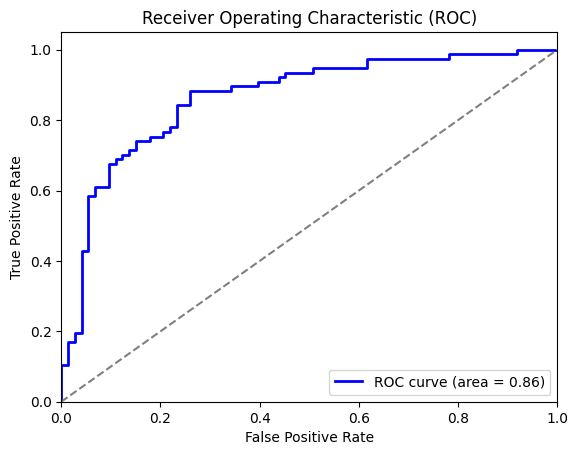

In [ ]:
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
binarizer = LabelBinarizer()
y_test_bin = binarizer.fit_transform(y_test)
y_pred_prob = nb_model.predict_proba(X_test)
false_positive_rate, true_positive_rate, _ = roc_curve(y_test_bin, y_pred_prob[:, 1])
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc(false_positive_rate, true_positive_rate))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.0023479371459152825


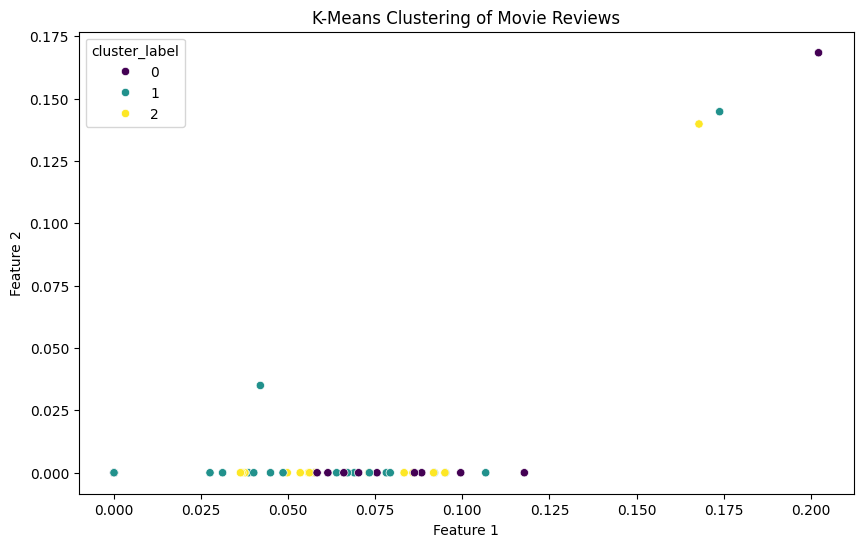

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Number of clusters can be adjusted
kmeans.fit(features)
data['cluster_label'] = kmeans.labels_
silhouette_avg = silhouette_score(features, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=data['cluster_label'], palette='viridis', legend='full')
plt.title('K-Means Clustering of Movie Reviews')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

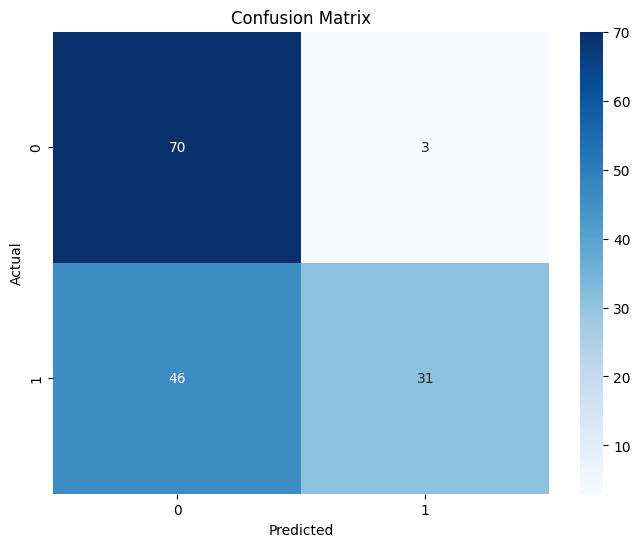

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'alpha': 0.1}
Best cross-validation score: 0.71
